In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
import matplotlib.image as mpimg 
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report

## Daten Importierung

In [3]:
import os 
from glob import glob 
print(os.listdir("../data/processed/val"))
path_train =  '../data/processed/train/'
path_test = '../data/processed/test/'
path_val= '../data/processed/val/'


['NORMAL', 'PNEUMONIA']


## Daten Aufbereitung

In [4]:
path_train_pneumonia =  '../data/processed/train/PNEUMONIA'
path_train_normal = '../data/processed/train/NORMAL'
path_test_normal = '../data/processed/test/NORMAL'
path_test_pneumonia = '../data/processed/test/PNEUMONIA'
path_val_normal =  '../data/processed/val/NORMAL'
path_val_pneumonia =  '../data/processed/val/PNEUMONIA'

In [5]:
images_path = glob(path_train_normal+"/*.jpeg")
images = []
for  path in images_path:    
     images.append((path,0))
Pneumonia_images_path =  glob(path_train_pneumonia+"/*.jpeg")
for path in Pneumonia_images_path:
    images.append((path,1))


<AxesSubplot:ylabel='labels'>

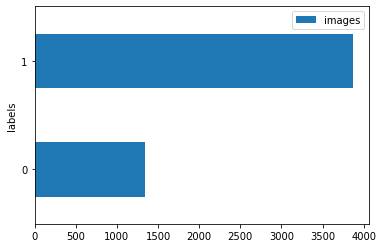

In [6]:
df = pd.DataFrame(images, columns=['images','labels'])
df.groupby('labels').count().plot.barh()

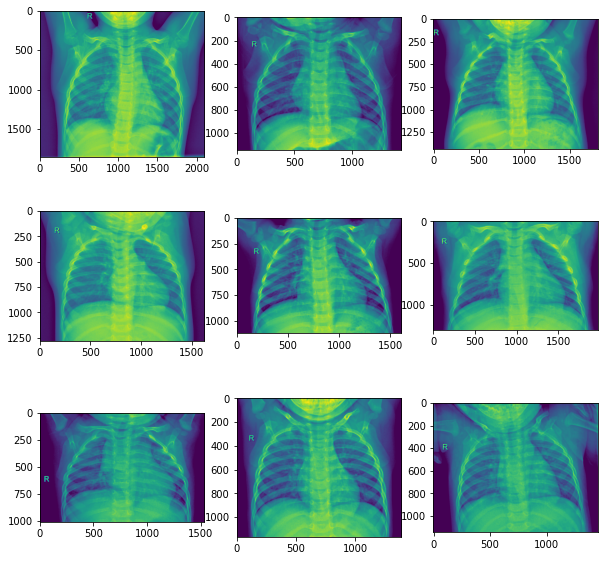

In [7]:
plt.figure(figsize=(10,10))
im = []
for i in range(0,10):
    im.append(plt.imread(df.loc[i].images))
len(im)
for i in range(0,9):
    plt.subplot(3, 3, i+1)
    plt.imshow(im[i])


## Probleme:

    - Data nicht balanciert bzw nicht genug images mit 0 als Label.
    - Die Bilder haben nicht die gleiche Größe.
    
## Lösungen:
    - Data-Augmentation verwenden.
    - Die Größe der Bilder ändern.

In [8]:
IMG_SIZE = 150 #auf Speicher Gründe muss die Bildgröße wie klein wie möglich sein
BATCH_SIZE = 32

Im medizinischen Bereich ist es üblich, dass die Daten unausgewogen sind, deshalb brauchen wir hier eine Data Augmentation.

## Daten Augmentation

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


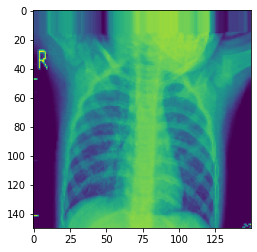

In [9]:

img_generator =keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                            rotation_range=10,
                                                            shear_range=0.2,
                                                            zoom_range=0.2,
                                                            width_shift_range=0.1,
                                                            height_shift_range=0.1,
                                                            horizontal_flip=True)



train_generator = img_generator.flow_from_directory(path_train,
                                                  target_size=(IMG_SIZE, IMG_SIZE),
                                                  batch_size=BATCH_SIZE,
                                                  color_mode="grayscale",
                                                  shuffle=True,
                                                  class_mode='binary', 
                                                  subset='training')

val_generator  = img_generator.flow_from_directory(path_val,
                                                  target_size=(IMG_SIZE, IMG_SIZE),
                                                  #batch_size= BATCH_SIZE,
                                                  color_mode="grayscale",
                                                  shuffle=False,
                                                  class_mode='binary',
                                                  )

test_generator = img_generator.flow_from_directory(path_test,
                                                  target_size=(IMG_SIZE, IMG_SIZE),
                                                  color_mode="grayscale",
                                                  shuffle=False,
                                                  class_mode='binary')
plt.imshow(train_generator[0][0][0])

# Convolutional neural network

<img src="Image.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" />
     
<p>ConvLayers haben die Aufgabe, die Merkmale der Bilder zu extrahieren, und die Fully Connected Layers sind für die Klassifikation zuständig.</p>

## MaxPooling

<img src="Max_pooling.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" />
     
<p> Die Max-Pooling nimmt von jeder Sub-Region der Feature-Map den größten Wert .</p>

## Building a CNN Model

In [50]:
# sequential model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
# layers
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization

In [59]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001) #0.00001 reduce the learning rate when the metrics isnt improving
early_stoping = EarlyStopping(patience = 5)
callback = [learning_rate_reduction,early_stoping]


In [80]:
cnn_model =  Sequential()
cnn_model.add(Conv2D(32,(3,3), activation ='relu', input_shape=(IMG_SIZE , IMG_SIZE,1)))#Convlayer mit 32 Filtern der Größe 3x3. 
cnn_model.add(Conv2D(32, (3,3),activation='relu')) #increase the non-linearity
cnn_model.add(MaxPool2D(2,2)) #die features-Maps werden als 2x2 array transformiert
cnn_model.add(Dropout(0.5))

cnn_model.add(Conv2D(64, (3,3), activation='relu'))
cnn_model.add(Conv2D(64, (3,3), activation='relu'))
cnn_model.add(MaxPool2D(2,2))
cnn_model.add(Dropout(0.5))


cnn_model.add(Conv2D(128, (3,3), activation='relu'))
cnn_model.add(Conv2D(128, (3,3), activation='relu'))
cnn_model.add(MaxPool2D(2,2))
cnn_model.add(Dropout(0.5))


cnn_model.add(Conv2D(256, (3,3), activation='relu'))
cnn_model.add(Conv2D(256, (3,3), activation='relu'))
cnn_model.add(MaxPool2D(2,2))


cnn_model.add(Flatten())#Matrizendaten abflachen, weil die Fully-Connected layer die Daten als Vector nimmt.
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_99 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 71, 71, 64)        18496     
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 69, 69, 64)        36928     
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 34, 34, 64)      

In [70]:
model = cnn_model.fit_generator(train_generator,
                                steps_per_epoch = 163,
                                epochs = 10,
                                validation_data=val_generator,
                                validation_steps=len(val_generator),
                                callbacks = callback)

Epoch 1/10
163/163 [==============================] - 420s 3s/step - loss: 0.5795 - accuracy: 0.7410 - val_loss: 0.7981 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 498s 3s/step - loss: 0.4978 - accuracy: 0.7671 - val_loss: 0.5975 - val_accuracy: 0.7500
Epoch 3/10
163/163 [==============================] - 515s 3s/step - loss: 0.3732 - accuracy: 0.8353 - val_loss: 0.6947 - val_accuracy: 0.6875
Epoch 4/10
162/163 [============================>.] - ETA: 3s - loss: 0.3370 - accuracy: 0.8503
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
163/163 [==============================] - 521s 3s/step - loss: 0.3369 - accuracy: 0.8505 - val_loss: 0.5715 - val_accuracy: 0.6875
Epoch 5/10
163/163 [==============================] - 466s 3s/step - loss: 0.2899 - accuracy: 0.8800 - val_loss: 1.1342 - val_accuracy: 0.5625
Epoch 6/10
162/163 [============================>.] - ETA: 2s - loss: 0.2698 - accuracy: 0.8862
Epoch 00006: ReduceLROnP

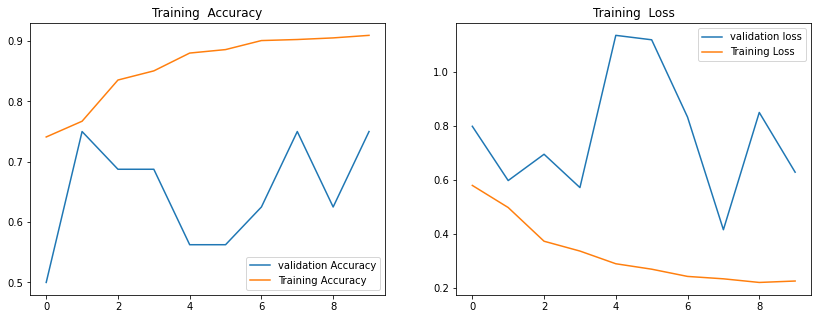

In [71]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(model.history['val_accuracy'],label='validation Accuracy')
plt.plot(model.history['accuracy'], label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training  Accuracy')

plt.subplot(1, 2, 2)
plt.plot(model.history['val_loss'],label='validation loss')
plt.plot(model.history['loss'], label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training  Loss')

plt.show()

##  Model evaluation

In [72]:
predic= cnn_model.evaluate(test_generator)
predictions =  cnn_model.predict_generator(test_generator)

20/20 [==============================] - 14s 715ms/step - loss: 0.4328 - accuracy: 0.8285


## Classification report

In [73]:
CNN_prediction_final = np.where(predictions>0.5,1,0)
print(classification_report(test_generator.classes,CNN_prediction_final , target_names = ['Pneumonia (Class 1)','Normal (Class 0)']))

                     precision    recall  f1-score   support

Pneumonia (Class 1)       0.94      0.58      0.72       234
   Normal (Class 0)       0.80      0.98      0.88       390

           accuracy                           0.83       624
          macro avg       0.87      0.78      0.80       624
       weighted avg       0.85      0.83      0.82       624



## Confusion Matrix

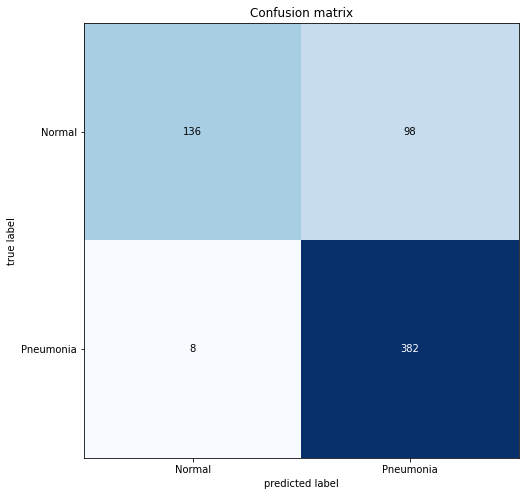

In [74]:
# Get the confusion matrix
CM = confusion_matrix(test_generator.classes, CNN_prediction_final)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(8,8))
plt.title('Confusion matrix')
plt.xticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.yticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.show()

## ROC CNN

AUC Score: 0.9279311856234933


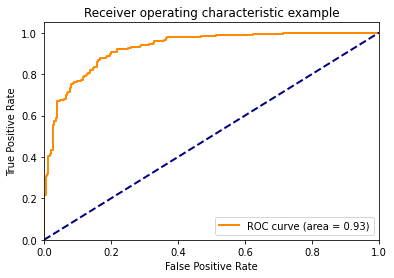

In [75]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr , tpr , thresholds = roc_curve ( test_generator.classes , predictions)
auc_keras = auc(fpr, tpr)
print("AUC Score:",auc_keras)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_keras)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Activation layers Visualization


In [76]:
from tensorflow.keras.models import Model
layer_outputs = [layer.output for layer in cnn_model.layers[:len(cnn_model.layers)]]

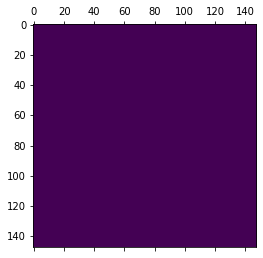

In [77]:
activation_model = Model(inputs=cnn_model.input, outputs=layer_outputs)
activations = activation_model.predict(test_generator[0])
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

C:\Users\nouam\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


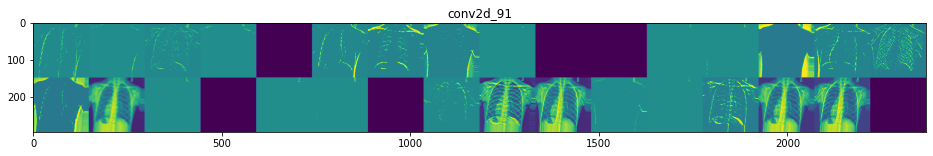

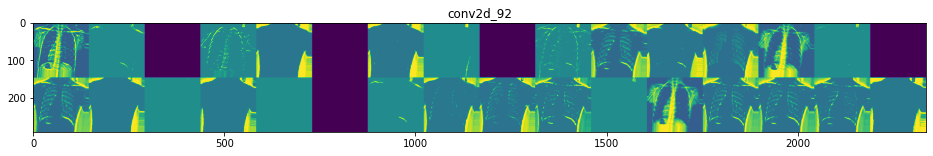

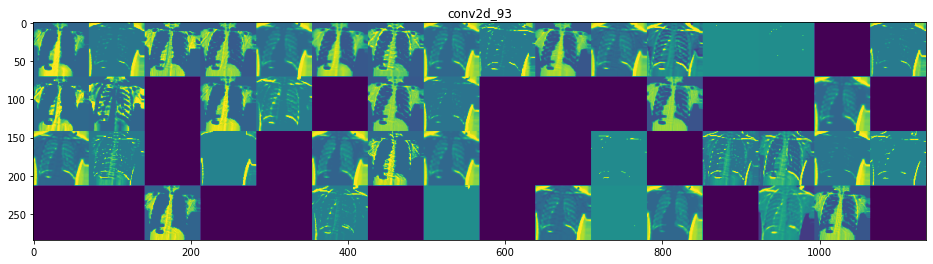

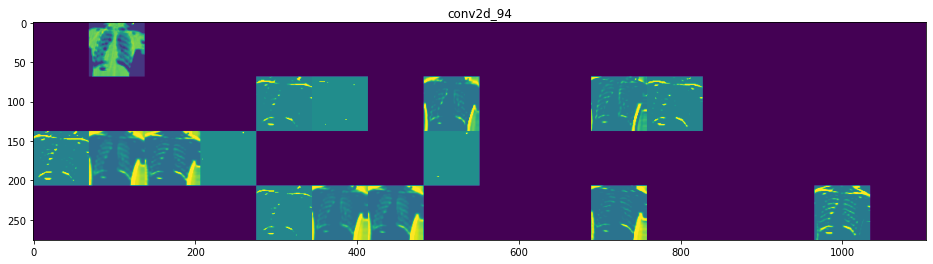

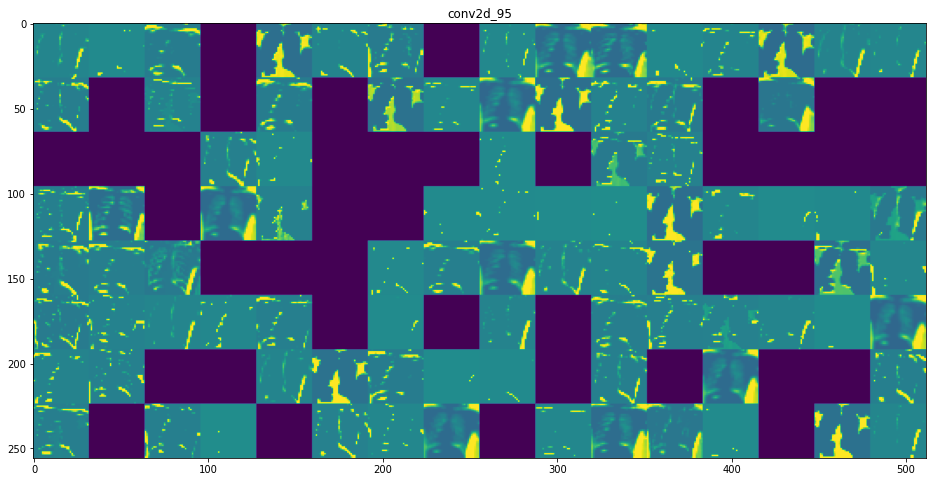

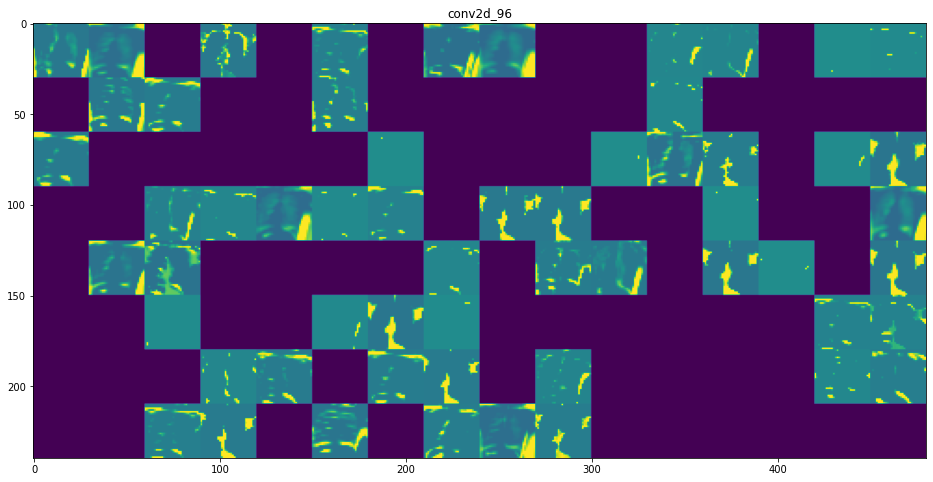

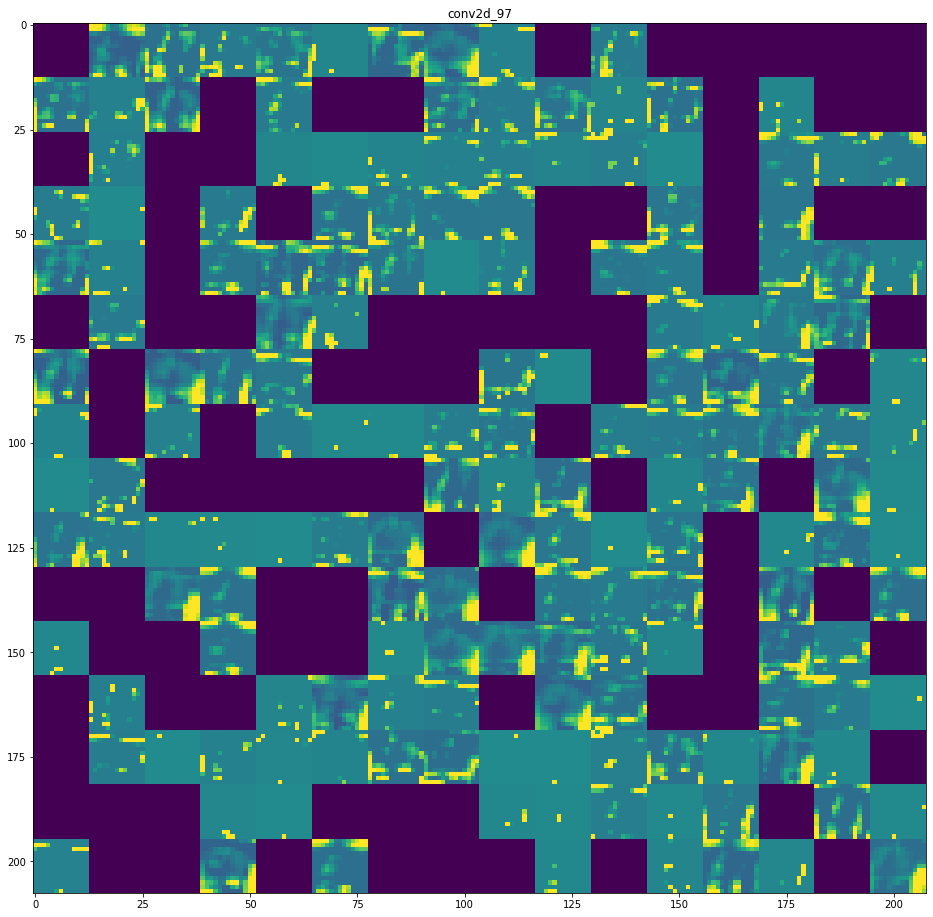

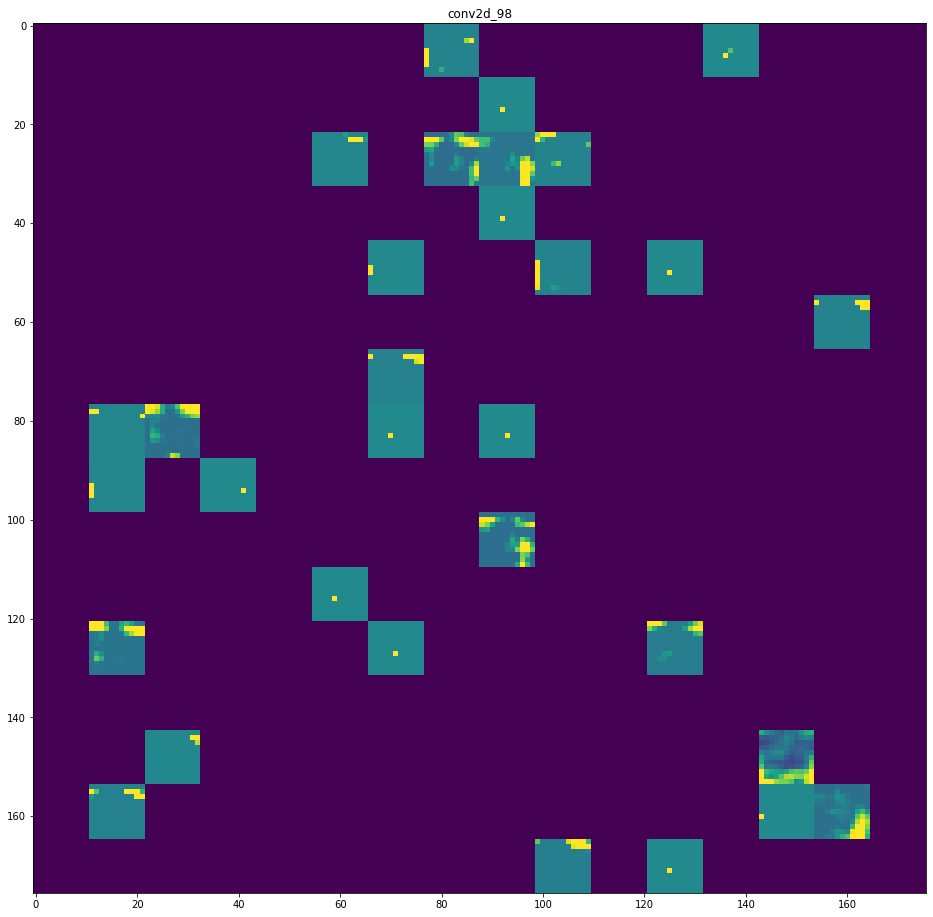

In [78]:
layer_names = []
for layer in cnn_model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
zipped_layers = zip(layer_names, activations)
for layer_name, layer_activation in zipped_layers: #this loop     
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

C:\Users\nouam\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


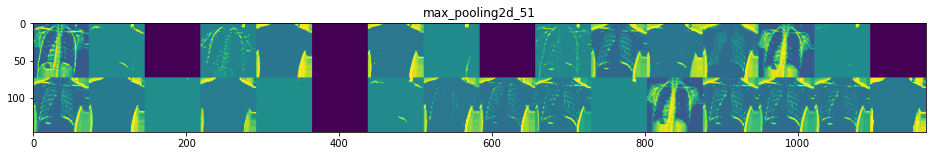

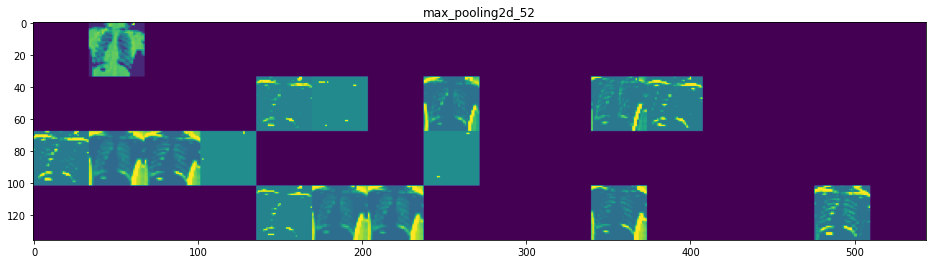

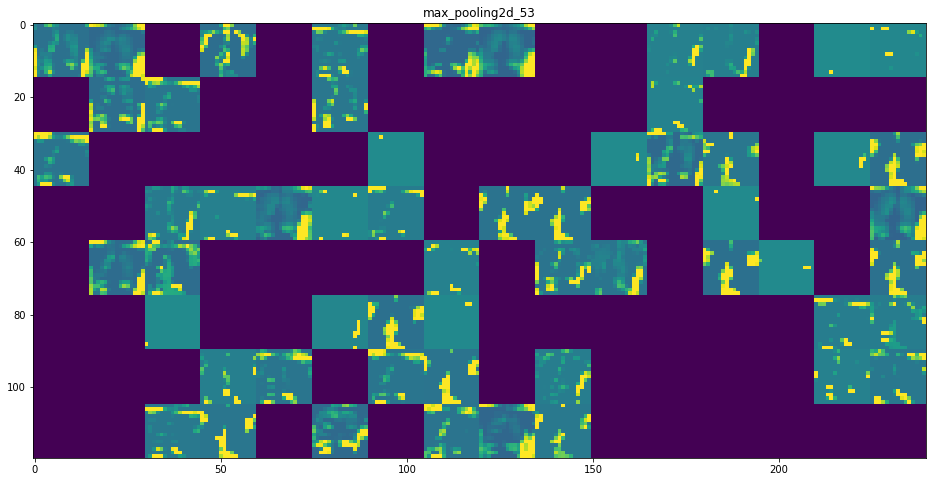

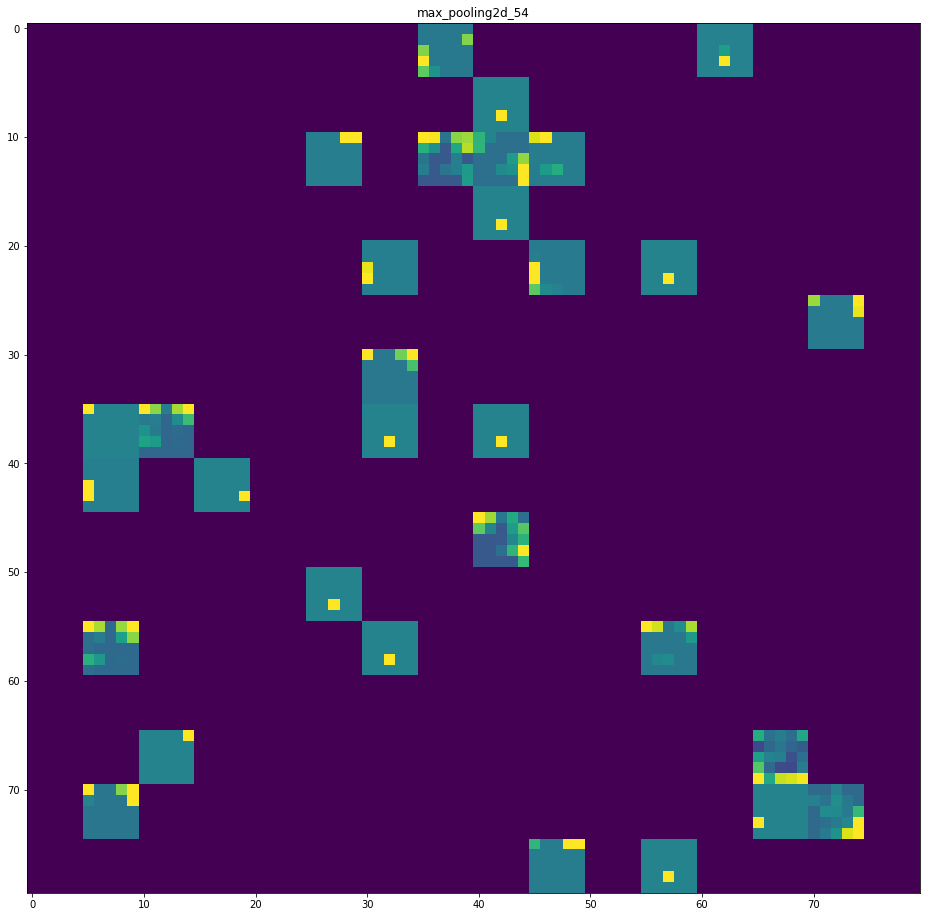

In [79]:
for layer in cnn_model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('max'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')